# ml-7 Практика

## Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [40]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

plt.style.use('seaborn')

random_state = 42

### Загрузка и исследование данных

In [4]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Проверяем наличие пропусков

data.isnull().sum().value_counts()

0    1777
dtype: int64

In [6]:
# типы данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


<AxesSubplot: xlabel='Activity', ylabel='count'>

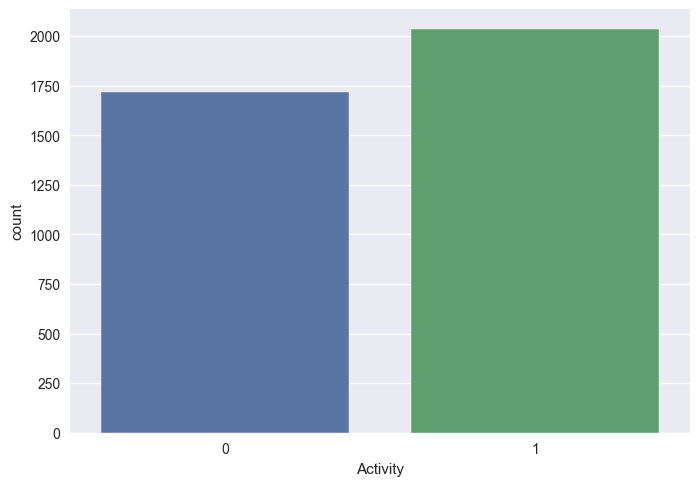

In [7]:
# сбалансированность классов

sns.countplot(data=data, x='Activity')

In [8]:
# матрица наблюдений - X
# вектор ответов - y

X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [9]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state, test_size=0.2)

## LogisticRegression

Получим метрики, без дополнительной настройки, со значениями гиперпараметров, установленных по умолчанию.

In [10]:
# объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(max_iter=1000, random_state=42)

# обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
# выводим значения метрики на тестовой выборке
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.777


### Оптимизация гиперпараметров модели

#### GridSearchCV

In [11]:
# сетка гиперпараметров в виде списка словарей
param_grid = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9]
    }
]

# объект класса GridSearch
grid_search = GridSearchCV(
        estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=1000  # количество итераций на сходимость
    ),
    param_grid=param_grid,
    cv=5,  #количество фолдов кросс-валидации
    n_jobs=-1
)

%time grid_search.fit(X_train, y_train)

y_test_pred = grid_search.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search.best_params_}')

CPU times: total: 1.72 s
Wall time: 8min 49s
f1_score на тестовом наборе: 0.778
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}


Метрику удалось улучшить незначительно по сравнению с параметрами, заданными по-умолчанию.

#### RandomizedSearchCV

In [12]:
# сетка гиперпараметров в виде списка словарей
param_distributions = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float))  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# объект класса RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=1000),
    param_distributions=param_distributions,
    cv=5,  # количество фолдов кросс-валидации
    n_iter=20,  # количество итераций
    n_jobs=-1
)

%time random_search.fit(X_train, y_train)

y_test_pred = random_search.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 1.14 s
Wall time: 3min 41s
f1_score на тестовом наборе: 0.783
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.45}


Метрику удалось ещё незначительно улучшить по сравнению с GridSearch, при этом методы предложили разные алгоритмы оптимизации.

#### Hyperopt

In [13]:
def hyperopt_rf(
        params,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params = {
        'penalty': params['penalty'],
        'solver': params['solver'],
        'C': params['C']
    }

    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=1000
    )

    model.fit(X, y)

    # применим  cross validation с количеством фолдов по-умолчанию
    score = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='f1',
        n_jobs=-1
    ).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [14]:
# пространство поиска гиперпараметров
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'C': hp.uniform('C', 0.01, 1)
}

In [15]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(
    hyperopt_rf,
    space=space,        # пространство гиперпараметров
    algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20,       # максимальное количество итераций
    trials=trials,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 20/20 [16:10<00:00, 48.51s/trial, best loss: -0.790061890715737]
Наилучшие значения гиперпараметров {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
CPU times: total: 8min 9s
Wall time: 16min 10s


In [16]:
# точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state,
    penalty='l1',
    solver='saga',
    C=best['C'],
    max_iter=1000
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.783


На тестовой выборке предложенные значения гиперпараметров показали тот же результат, что и значения по умолчанию.

#### Optuna

In [46]:
def optuna_rf(trial):
    # пространство поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', 0.01, 1)

    model = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=1000,
        random_state=random_state
    )

    model.fit(X_train, y_train)

    # применим cross validation с тем же количеством фолдов
    score = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=-1
    ).mean()

    return score

In [47]:
%%time
# объект исследования
study = optuna.create_study(
    study_name='LogisticRegression',
    direction='maximize'
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.20409327819391074}
f1_score на обучающем наборе: 0.790
CPU times: total: 9min 23s
Wall time: 20min


In [48]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, max_iter=1000, random_state=random_state)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.781


In [49]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Optuna предложила значения параметров, которые дали результат, близкий к результату, полученному от параметров, заданных по-умолчанию.

## RandomForest

In [21]:
# объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.805


Случайный лес сразу выдает результаты, лучше, чем у логистической регресии

### Оптимизация гиперпараметров модели

#### GridSearchCV

In [22]:
param_grid = {
    'n_estimators': list(range(80, 200, 20)),
    'min_samples_leaf': list(range(1, 10, 1)),
    'max_depth': list(np.linspace(20, 40, 5, dtype=int))
}

grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

%time grid_search_forest.fit(X_train, y_train)

y_test_pred = grid_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

CPU times: total: 12.6 s
Wall time: 7min 56s
f1_score на тестовом наборе: 0.804
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 180}


#### RandomizedSearchCV

In [23]:
param_distributions = {
    'n_estimators': list(range(80, 200, 20)),
    'min_samples_leaf': list(range(1, 10, 1)),
    'max_depth': list(np.linspace(20, 40, 5, dtype=int))
}

random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions,
    cv=5,
    n_iter=30,
    n_jobs=-1
)

%time random_search_forest.fit(X_train, y_train)

y_test_pred = random_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

CPU times: total: 4.33 s
Wall time: 56.9 s
f1_score на тестовом наборе: 0.800
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 180}


#### Hyperopt

In [33]:
def hyperopt_rf(
        params,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }

    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    model.fit(X, y)

    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [34]:
space = {
    'n_estimators': hp.quniform('n_estimators', 80, 200, 1),
    'max_depth' : hp.quniform('max_depth', 10, 40, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

In [36]:
%%time

trials = Trials()

best = fmin(
    hyperopt_rf,
    space=space,        # пространство гиперпараметров
    algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=30,       # максимальное количество итераций
    trials=trials,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 30/30 [02:40<00:00,  5.35s/trial, best loss: -0.8170207402042676]
Наилучшие значения гиперпараметров {'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 159.0}
CPU times: total: 1min 6s
Wall time: 2min 40s


In [37]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.803


#### Optuna

In [28]:
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 80, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    score = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=-1
    ).mean()

    return score

In [41]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'n_estimators': 185, 'max_depth': 36, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.817
CPU times: total: 1min 15s
Wall time: 3min 10s


In [43]:
# точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе: 0.800
